In [1]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

fatal: destination path 'yolov5' already exists and is not an empty directory.
/home/eddi/proj/Carla-Proj-1/workspace/ugly_test/wjh/yolov5
HEAD is now at 064365d8 Update parse_opt() in export.py to work as in train.py (#10789)


In [2]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.2.2+cu121 _CudaDeviceProperties(name='NVIDIA GeForce RTX 4060 Laptop GPU', major=8, minor=9, total_memory=7940MB, multi_processor_count=24)


In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="8YmtafoHQdc9PTNlH86Y")
project = rf.workspace("muhammad-syihab-bdynf").project("parking-space-ipm1b")
version = project.version(4)
dataset = version.download("yolov5")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 1.9 MB/s eta 0:00:0031m158.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.5 MB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: cycler
    Found existing installation: cycler 0.11.0
    Uninstalling cycler-0.11.0:
      Successfully uninstalled cycler-0.11.0
  Attempting uninstall: certifi
    Found existing installation: certifi 2024.2.2
    Uninstalling certifi-2024.2.2:
      Successfully uninstalled certifi-2024.2.2
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Parking-Space-4 in yolov5pytorch:: 100%|█| 15614/15614 [00:01<0


In [5]:
%cd /home/eddi/proj/Carla-Proj-1/workspace/ugly_test/wjh/yolov5

/home/eddi/proj/Carla-Proj-1/workspace/ugly_test/wjh/yolov5


In [6]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- empty
- occupied
nc: 2
roboflow:
  license: CC BY 4.0
  project: parking-space-ipm1b
  url: https://universe.roboflow.com/muhammad-syihab-bdynf/parking-space-ipm1b/dataset/4
  version: 4
  workspace: muhammad-syihab-bdynf
test: ../test/images
train: Parking-Space-4/train/images
val: Parking-Space-4/valid/images


In [7]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [9]:
#this is the model configuration we will use for our tutorial
%cat /home/eddi/proj/Carla-Proj-1/workspace/ugly_test/wjh/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [10]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [16]:
# train yolov5s on custom data for 100 epochs
# time its performance
%cd /home/eddi/proj/Carla-Proj-1/workspace/ugly_test/wjh/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/home/eddi/proj/Carla-Proj-1/workspace/ugly_test/wjh/yolov5
2024-04-19 16:18:33.144019: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 16:18:34.017191: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/home/eddi/proj/Carla-Proj-1/workspace/ugly_test/wjh/yolov5/Parking-Space-4/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, 

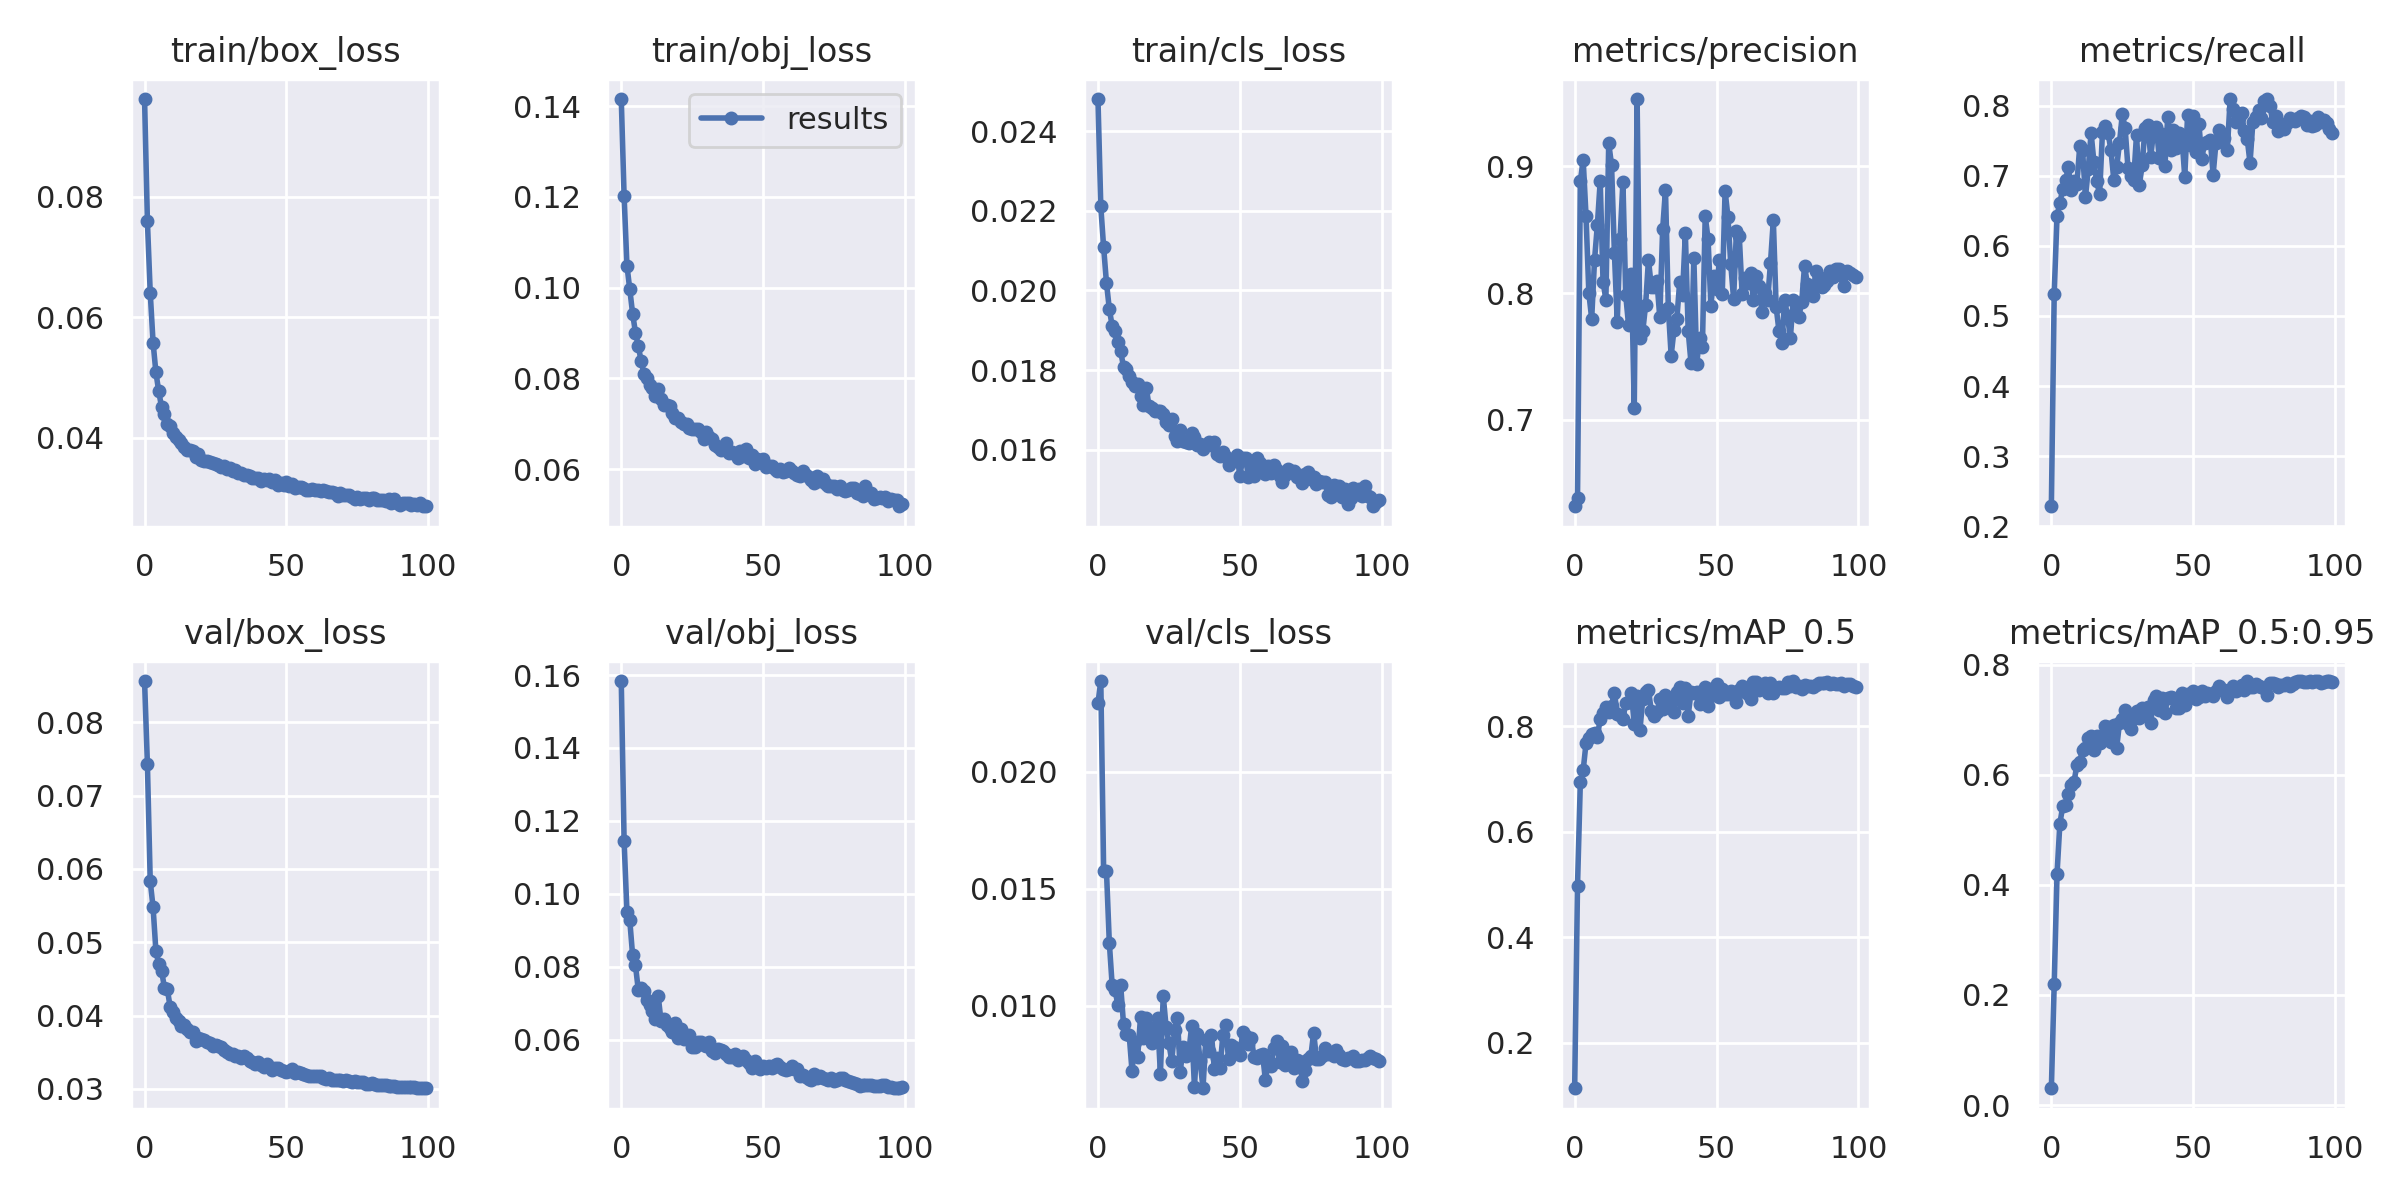

In [17]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/home/eddi/proj/Carla-Proj-1/workspace/ugly_test/wjh/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

In [18]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [19]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [4]:
%cd /home/eddi/proj/Carla-Proj-1/workspace/ugly_test/wjh/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.2 --source /home/eddi/proj/Carla-Proj-1/workspace/ugly_test/wjh/_out/13.png
     

/home/eddi/proj/Carla-Proj-1/workspace/ugly_test/wjh/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=/home/eddi/proj/Carla-Proj-1/workspace/ugly_test/wjh/_out/13.png, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.2, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.11.7 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7940MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7249215 parameters, 0 gradients
image 1/1 /home/eddi/proj/Carla-Proj-1/workspace/ugly_test/wjh/_out/13.png: 256x416 (no detections), 180.9ms
Speed: 1.5ms pre-process, 180.9ms inference, 27.3ms NMS per image at shape (1, 3, 416, 416)
Results s